In [1]:
import numpy as np
import pandas as pd
import load_data as ld
from utils import RMSE 
import copy
from timeit import default_timer as timer
from sklearn.model_selection import train_test_split

In [4]:
class PMF():
    
    def __init__(self, R, val_R, latent_size=50, ld=1e-3, lr=0.001, epochs=200, constrain=False):
        
        self._R = R
        self._val_R = val_R
        self._N, self._M = R.shape
        self._epochs =epochs
        self._lr = lr
        self._I = copy.deepcopy(self._R)
        self._I[self._I != 0] = 1
        self._Y = np.random.normal(0, 0.1, size=(self._N, latent_size))
        self._V = np.random.normal(0, 0.1, size=(self._M, latent_size))
        self._lambda = ld
        self._constrain = constrain
        if constrain:
            self._W = np.random.normal(0, 0.1, size=(self._M, latent_size))
        
    def get_grad_uncon(self):
        # derivate of U
        grads_u = np.dot(self._I*(self._R-np.dot(self._Y, self._V.T)), -self._V) + self._lambda*self._Y

        # derivate of V
        grads_v = np.dot((self._I*(self._R-np.dot(self._Y, self._V.T))).T, -self._Y) + self._lambda*self._V   
        return grads_u, grads_v

    def get_grad_con(self):
        
        uw = np.zeros(self._Y.shape)
        for i in range(self._N):
            uw[i, :] = np.matmul(self._I[i, :],self._W) / np.sum(self._I[i, :])

        pred = np.dot(self._Y+uw, self._V.T)
        gd_uw = np.zeros(self._R.shape)
        for i in range(self._N):
            gd_uw[i, :] = self._I[i, :] / np.sum(self._I[i, :])
                
        # derivate of Y
        grads_y = np.dot(self._I*(self._R-pred), -self._V) + self._lambda*self._Y

        # derivate of V
        grads_v = np.dot((self._I*(self._R-pred)).T, -(self._Y+uw)) + self._lambda*self._V  

        # derivate of V
        grads_w = np.dot((self._I*(self._R-pred)).T, -np.dot(gd_uw, self._V)) +self._lambda*self._W  

        return grads_y, grads_v, grads_w


    def train(self):
        
        train_rmse_list = []
        vali_rmse_list = []
        last_vali_rmse = None

        time = 0
        start_time = timer()
        for epoch in range(self._epochs):
            start = timer()

            if self._constrain == False:
                grads_u, grads_v = self.get_grad_uncon()
            else:
                grads_u, grads_v, grads_w = self.get_grad_con()
                self._W = self._W - self._lr * grads_w

            # update the parameters            
            self._Y = self._Y - self._lr * grads_u
            self._V = self._V - self._lr * grads_v   

            if self._constrain == False:
                train_rmse = RMSE(self._R, np.matmul(self._Y, self._V.T))
                val_rmse =  RMSE(self._val_R, np.matmul(self._Y, self._V.T))
            else:
                uw = np.zeros(self._Y.shape)
                for i in range(self._N):
                    uw[i, :] = np.matmul(self._I[i, :],self._W) / np.sum(self._I[i, :])
                train_rmse = RMSE(self._R, np.matmul(self._Y+uw, self._V.T))
                val_rmse =  RMSE(self._val_R, np.matmul(self._Y+uw, self._V.T))
                
            time += timer() - start
            train_rmse_list.append(train_rmse)
            vali_rmse_list.append(val_rmse)
            
            print('traning iteration:{: d} ,train_RMSE:{: f}, val_RMSE:{: f}'.format(epoch, train_rmse, val_rmse))
            if last_vali_rmse and abs(last_vali_rmse - val_rmse) <= 0.00001:
                print('convergence at iterations:{: d}'.format(epoch))
                break
            else:
                last_vali_rmse = val_rmse
                
        print("Total time for training : %.4f" % (timer()-start_time))
        return self._Y, self._V, train_rmse_list, vali_rmse_list    

In [5]:
df = ld.load_rating_data()
N, M = len(df.user_id.unique()), len(df.item_id.unique())
ratio = 0.8
print("N, M : ", N, M)
train, test = train_test_split(df, test_size=1-ratio)
val, test = train_test_split(test, test_size=0.5)
train.reset_index(drop=True, inplace=True)
val.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

N, M :  943 1682


In [6]:
R = np.zeros([N, M])    
for i in range(len(train)):
    R[int(train.iloc[i, 0])-1, int(train.iloc[i, 1])-1] = float(train.iloc[i, 2])

val_R = np.zeros([N, M])    
for i in range(len(val)):
    val_R[int(val.iloc[i, 0])-1, int(val.iloc[i, 1])-1] = float(val.iloc[i, 2])

In [7]:
pmf1 = PMF(R, val_R, latent_size=20, ld=0.001, lr=0.0005, epochs=100, constrain=False)
U1, V1, train_rmse_list1, val_rmse_list1 = pmf1.train()

traning iteration: 0 ,train_RMSE: 3.708347, val_RMSE: 3.681062
traning iteration: 1 ,train_RMSE: 3.707544, val_RMSE: 3.680998
traning iteration: 2 ,train_RMSE: 3.706652, val_RMSE: 3.680848
traning iteration: 3 ,train_RMSE: 3.705594, val_RMSE: 3.680539
traning iteration: 4 ,train_RMSE: 3.704264, val_RMSE: 3.679970
traning iteration: 5 ,train_RMSE: 3.702497, val_RMSE: 3.678985
traning iteration: 6 ,train_RMSE: 3.700044, val_RMSE: 3.677345
traning iteration: 7 ,train_RMSE: 3.696516, val_RMSE: 3.674679
traning iteration: 8 ,train_RMSE: 3.691307, val_RMSE: 3.670405
traning iteration: 9 ,train_RMSE: 3.683481, val_RMSE: 3.663623
traning iteration: 10 ,train_RMSE: 3.671593, val_RMSE: 3.652946
traning iteration: 11 ,train_RMSE: 3.653450, val_RMSE: 3.636263
traning iteration: 12 ,train_RMSE: 3.625789, val_RMSE: 3.610435
traning iteration: 13 ,train_RMSE: 3.583932, val_RMSE: 3.570950
traning iteration: 14 ,train_RMSE: 3.521559, val_RMSE: 3.511700
traning iteration: 15 ,train_RMSE: 3.431018, val_R

In [6]:
pmf_c = PMF(R, val_R, latent_size=20, ld=0.001, lr=0.0005, epochs=100, constrain=True)
# regression parameter 2개
U_c, V_c, train_rmse_list_c, val_rmse_list_c = pmf_c.train()

traning iteration: 0 ,train_RMSE: 3.704556, val_RMSE: 3.693730
traning iteration: 1 ,train_RMSE: 3.703392, val_RMSE: 3.693314
traning iteration: 2 ,train_RMSE: 3.701856, val_RMSE: 3.692528
traning iteration: 3 ,train_RMSE: 3.699556, val_RMSE: 3.690992
traning iteration: 4 ,train_RMSE: 3.695810, val_RMSE: 3.688042
traning iteration: 5 ,train_RMSE: 3.689375, val_RMSE: 3.682469
traning iteration: 6 ,train_RMSE: 3.677978, val_RMSE: 3.672062
traning iteration: 7 ,train_RMSE: 3.657492, val_RMSE: 3.652806
traning iteration: 8 ,train_RMSE: 3.620593, val_RMSE: 3.617574
traning iteration: 9 ,train_RMSE: 3.554837, val_RMSE: 3.554231
traning iteration: 10 ,train_RMSE: 3.440876, val_RMSE: 3.443835
traning iteration: 11 ,train_RMSE: 3.253975, val_RMSE: 3.261908
traning iteration: 12 ,train_RMSE: 2.976650, val_RMSE: 2.990362
traning iteration: 13 ,train_RMSE: 2.628643, val_RMSE: 2.646650
traning iteration: 14 ,train_RMSE: 2.284886, val_RMSE: 2.303441
traning iteration: 15 ,train_RMSE: 2.016645, val_R

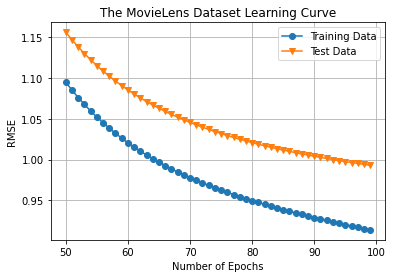

In [7]:
import matplotlib.pyplot as plt

# Check performance by plotting train and test errors
n = 100
m = 50
plt.plot(range(m, n), train_rmse_list1[m:n], marker='o', label='Training Data')
plt.plot(range(m, n), val_rmse_list1[m:n], marker='v', label='Test Data')
plt.title('The MovieLens Dataset Learning Curve')
plt.xlabel('Number of Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.show()

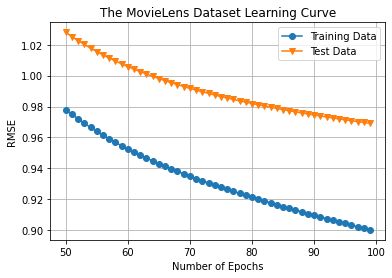

In [8]:
# Check performance by plotting train and test errors
n = 100
m = 50
plt.plot(range(m, n), train_rmse_list_c[m:n], marker='o', label='Training Data')
plt.plot(range(m, n), val_rmse_list_c[m:n], marker='v', label='Test Data')
plt.title('The MovieLens Dataset Learning Curve')
plt.xlabel('Number of Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.show()

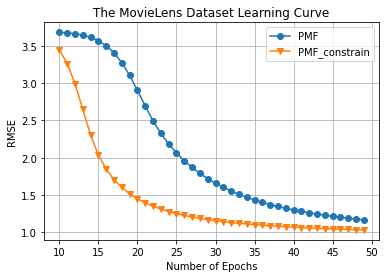

In [9]:
# Check performance by plotting train and test errors
n = 50
m = 10
plt.plot(range(m, n), val_rmse_list1[m:n], marker='o', label='PMF')
plt.plot(range(m, n), val_rmse_list_c[m:n], marker='v', label='PMF_constrain')
plt.title('The MovieLens Dataset Learning Curve')
plt.xlabel('Number of Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.show()

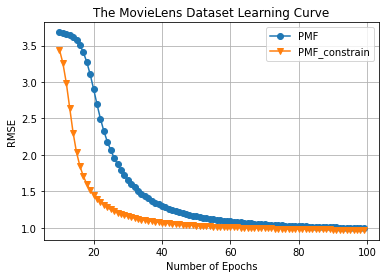

In [10]:
# Check performance by plotting train and test errors
n = 100
m = 10
plt.plot(range(m, n), val_rmse_list1[m:n], marker='o', label='PMF')
plt.plot(range(m, n), val_rmse_list_c[m:n], marker='v', label='PMF_constrain')
plt.title('The MovieLens Dataset Learning Curve')
plt.xlabel('Number of Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.show()